# Module 03: Spatial Analysis with Python

#### Rainey Aberle

#### Fall 2021

In this Jupyter notebook we use the `rasterio` library to compute the hypsometric curve of Reynolds Creek Experimental Watershed and Critical Zone Observatory from a 5 m resolution digital elevation model (DEM). The DEM was derived from Lidar data from a 2014 overflight of Reynolds Creek.

After deriving the hypsometric curve, an assignment then asks you to interpolate to find the threshold elevations corresponding to the 33rd and 66th percentiles in elevation. Based on those thresholds, you are then asked to screen out and plot the bottom and top 1/3 of the watershed.

More info on the rasterio library can be found here: https://rasterio.readthedocs.io/en/latest/

In [1]:
import rasterio as rio # Import rasterio
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib
from osgeo import gdal # Import GDAL (to plot image with coordinates)

# Set the name of the file that will be read, a GeoTiff with the 5m DEM:
dem_fname = 'rcew_dem_5m_.tif'

# Set the number of bins for the histogram
nbins = 35

#### Open the DEM and Explore the Metadata

In [2]:
rcew_dem = rio.open(dem_fname)
rcew_dem

<open DatasetReader name='rcew_dem_5m_.tif' mode='r'>

In [3]:
# View DEM metadata
# Note: Units = m
rcew_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.402823e+38,
 'width': 2940,
 'height': 5750,
 'count': 1,
 'crs': CRS.from_epsg(26911),
 'transform': Affine(5.0, 0.0, 511030.85,
        0.0, -5.0, 4795946.63)}

Read the Elevation Band of the Raster and Set the `NODATA` values to `NAN`

In [4]:
# Read the first time period and preview data
rcew_elev = rcew_dem.read(1)
rcew_elev

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [5]:
# Mask out no data values
rcew_elev = np.where(rcew_elev<0, np.nan, rcew_elev)

In [6]:
# Extract coordinates from file
ds = gdal.Open(dem_fname)
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 
# Approximate x and y coordinates
x = np.arange(minx,maxx+1,(maxx-minx)/(width-1))
y = np.arange(miny,maxy+1,(maxy-miny)/(height-1))

#### Plot the DEM

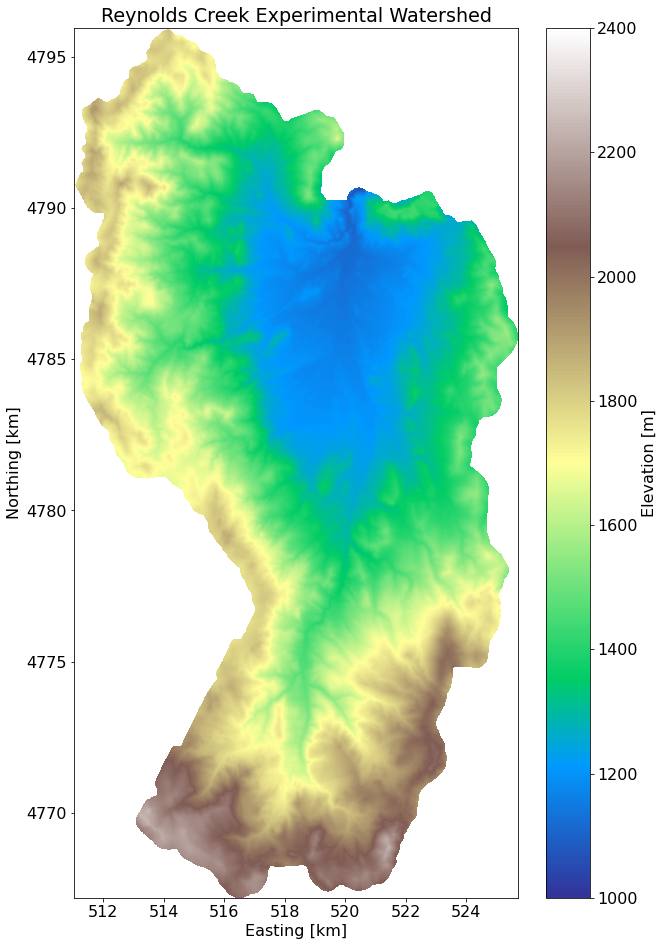

In [7]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,16))
plt.imshow(rcew_elev, cmap='terrain', extent=[minx/1e3,maxx/1e3,miny/1e3,maxy/1e3])
plt.clim(1000,2400)
plt.colorbar(label='Elevation [m]')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
plt.title('Reynolds Creek Experimental Watershed')
plt.show()

### Compute the Histogram of the Elevation Data
Use the `numpy.histogram()` function to compute the histogram of the elevation dataset, being careful to only pass the histogram function valid values of elevation. to do this we use the `~np.isnan` function to find the __indices of only those pixels that have non-nan values of elevation.__

In [8]:
# Make sure NaNs are non included in histogram computation
f_elev,b_elev = np.histogram(rcew_elev[~np.isnan(rcew_elev)], bins=nbins)
print('f_elev: ',f_elev)
print('b_elev: ',b_elev)

f_elev:  [  1619  11914 152342 438122 594588 501777 456786 510649 470118 430887
 471721 469855 477990 427215 363346 354675 396460 423829 457140 434510
 417715 476529 390886 251801 185235 169748 164541 182518 173834 153810
 170081 113015  91200  42992  10121]
b_elev:  [1048.7723 1082.9165 1117.0605 1151.2047 1185.3489 1219.4929 1253.6371
 1287.7812 1321.9253 1356.0695 1390.2136 1424.3577 1458.5018 1492.646
 1526.79   1560.9342 1595.0784 1629.2224 1663.3666 1697.5106 1731.6548
 1765.799  1799.943  1834.0872 1868.2313 1902.3754 1936.5195 1970.6637
 2004.8077 2038.9519 2073.096  2107.2402 2141.3843 2175.5283 2209.6726
 2243.8167]


Now get the bin centers by computing the midway point of all the bin edges. 

In [9]:
bin_centers = (b_elev[0:-1] + b_elev[1:])/2
bin_centers

array([1065.8445, 1099.9885, 1134.1326, 1168.2769, 1202.4209, 1236.565 ,
       1270.7092, 1304.8533, 1338.9973, 1373.1416, 1407.2856, 1441.4297,
       1475.574 , 1509.718 , 1543.862 , 1578.0063, 1612.1504, 1646.2944,
       1680.4386, 1714.5828, 1748.7268, 1782.871 , 1817.0151, 1851.1592,
       1885.3033, 1919.4475, 1953.5916, 1987.7357, 2021.8799, 2056.024 ,
       2090.168 , 2124.3123, 2158.4563, 2192.6006, 2226.7446],
      dtype=float32)

#### Plot the Histogram of Elevations

Text(0, 0.5, 'Count [-]')

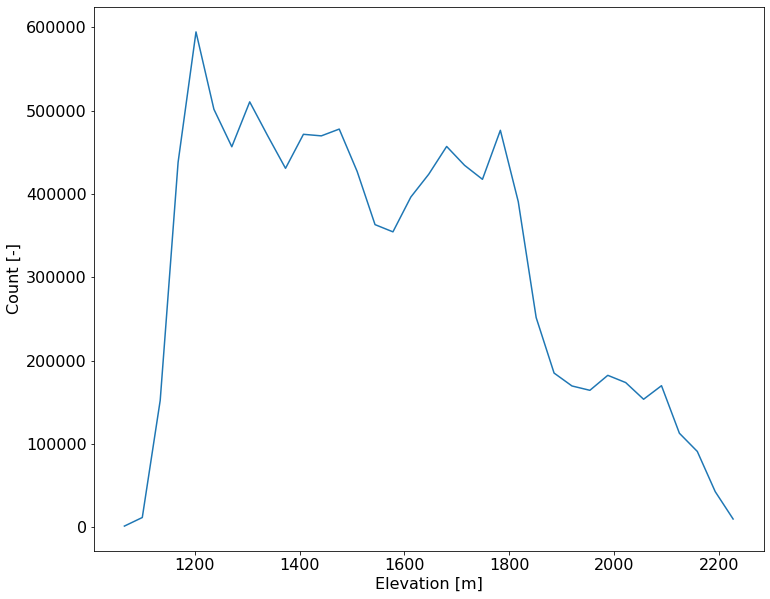

In [10]:
plt.figure(figsize=(12,10))
plt.plot(bin_centers, f_elev)
plt.xlabel('Elevation [m]')
plt.ylabel('Count [-]')

#### Compute the Hypsometric Curve
The hypsometric curve is essentially the cumulative density function of the elevation within the watershed. The y-axis should indicate the proportion of watershed (i.e., the fraction of area) that is above the a particular corresponding value of elevation on the x-axis.

In [11]:
hypso_rcew = 1.0 - np.cumsum(f_elev / np.sum(f_elev))
hypso_rcew

array([ 9.99850640e-01,  9.98751519e-01,  9.84697270e-01,  9.44278504e-01,
        8.89425032e-01,  8.43133800e-01,  8.00993194e-01,  7.53883480e-01,
        7.10512936e-01,  6.70761633e-01,  6.27243205e-01,  5.83896924e-01,
        5.39800153e-01,  5.00387608e-01,  4.66867271e-01,  4.34146874e-01,
        3.97571619e-01,  3.58471448e-01,  3.16298185e-01,  2.76212643e-01,
        2.37676516e-01,  1.93714529e-01,  1.57653501e-01,  1.34423703e-01,
        1.17334924e-01,  1.01674891e-01,  8.64952287e-02,  6.96571054e-02,
        5.36201209e-02,  3.94304423e-02,  2.37396893e-02,  1.33135367e-02,
        4.89991807e-03,  9.33708711e-04, -2.22044605e-16])

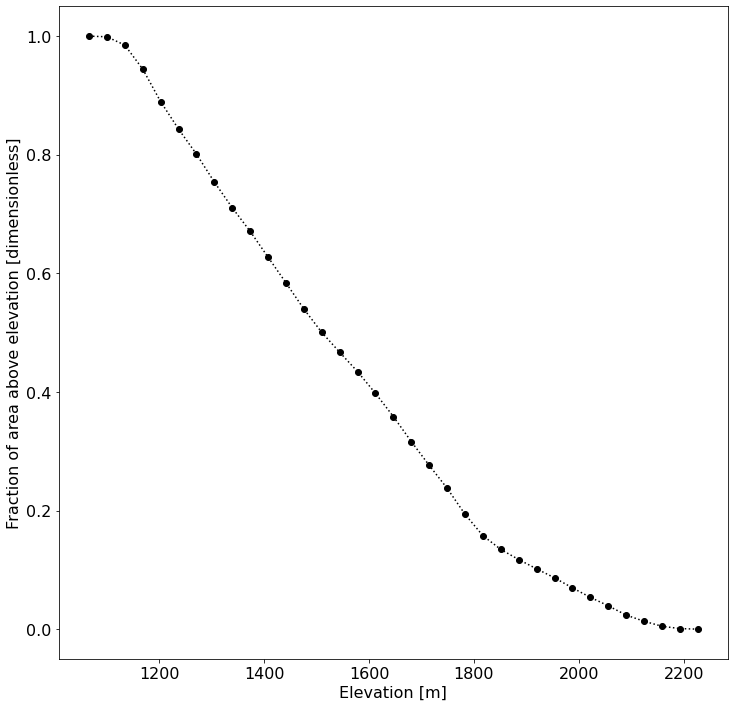

In [12]:
plt.figure(figsize=(12,12))
plt.plot(bin_centers,hypso_rcew,'ko:')
plt.xlabel('Elevation [m]')
plt.ylabel('Fraction of area above elevation [dimensionless]')
plt.show()

## Assignment
The assignment is to then use the numpy.interp() and numpy.where() functions to comute the elevations corresponding to the 33rd and 67th percentile in the above hypsometric curve. Then, based on those threshholds, you should create a spatial map of watershed elevation for the bottom 1/3 and top 1/3 in elevation for Reynolds Creek. The algorithm you should follow is below. Here are links to the documentation you might need:

- `numpy.interp():` https://numpy.org/doc/stable/reference/generated/numpy.interp.html
- `numpy.where():` https://numpy.org/doc/stable/reference/generated/numpy.where.html

#### Algorithm for Visualizing the Bottom and Top 1/3 of Elevation

1. Find the elevation corresponding to hypsometric curve values of (1/3) and (2/3), using `np.interp()` (call it, for instance, `z_33` and `z_66`)

In [13]:
z_66 = np.interp(1/3,np.flipud(hypso_rcew),np.flipud(bin_centers))
z_33 = np.interp(2/3,np.flipud(hypso_rcew),np.flipud(bin_centers))
print('z_33 = '+str(np.round_(z_33,decimals=1))+' m')
print('z_66 = '+str(np.round_(z_66,decimals=1))+' m')

z_33 = 1376.4 m
z_66 = 1666.6 m


2. Use the `np.where(rcew_elev < z_66, , )` to get the bottom 1/3 of elevations and...  

In [14]:
rcew_33 = np.where(rcew_elev<=z_33,rcew_elev,np.nan)
rcew_66 = np.where(rcew_elev>=z_66,rcew_elev,np.nan)

3. Use `plt.imshow()` to plot the Digital Elevation Models (DEMs) of the top and bottom 1/3 of the watersheds 

Text(0.5, 1.0, 'Bottom 1/3 elevations of the Watershed')

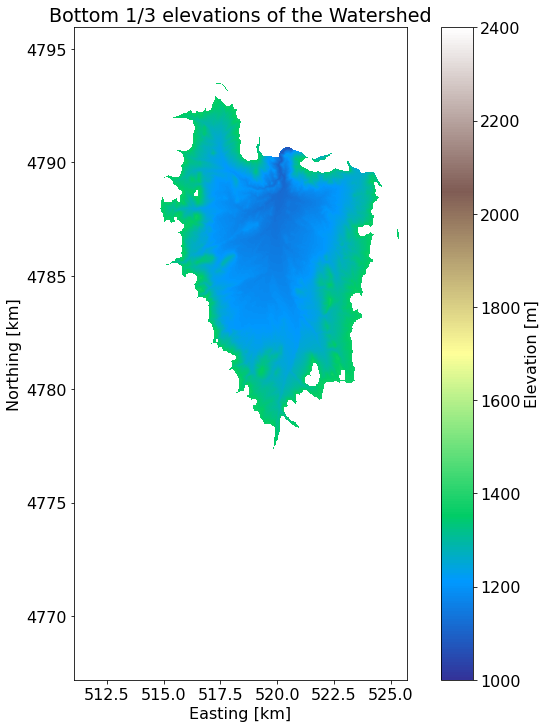

In [15]:
# Plot the DEM for the bottom 1/3 of the watershed
plt.figure(figsize=(12,12))
plt.imshow(rcew_33, cmap='terrain',extent=[minx/1e3,maxx/1e3,miny/1e3,maxy/1e3])
plt.clim(1000,2400)
plt.colorbar(label='Elevation [m]')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
plt.title('Bottom 1/3 elevations of the Watershed')

Text(0.5, 1.0, 'Top 1/3 Elevations of the Watershed')

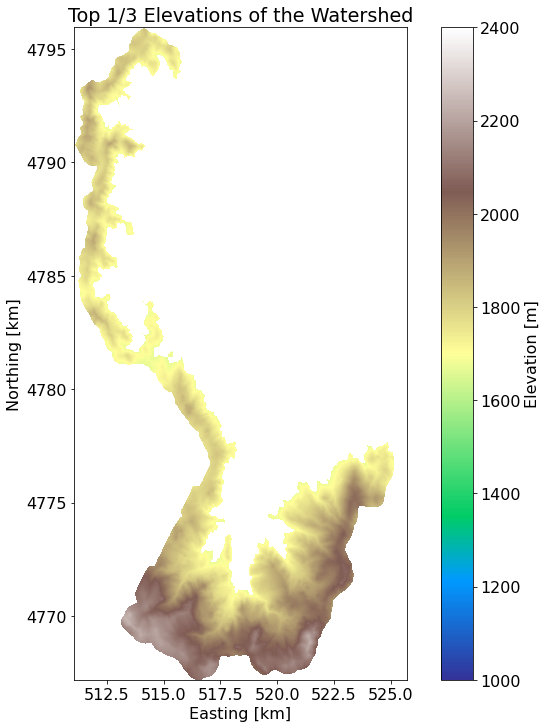

In [16]:
# Plot the DEM for the top 1/3 of the watershed
plt.figure(figsize=(12,12))
plt.imshow(rcew_66, cmap='terrain', extent=[minx/1e3,maxx/1e3,miny/1e3,maxy/1e3])
plt.clim(1000,2400)
plt.colorbar(label='Elevation [m]')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
plt.title('Top 1/3 Elevations of the Watershed')